## Deep Learning Final
casey.durfee@colorado.edu

I got weird results running on TPU. Use the GPU.

In this notebook, I am building a deep learning system to detect diseases of the Cassava plant based on this dataset. https://www.kaggle.com/datasets/mexwell/crop-diseases-classification

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print("Running on GPU.")
    else:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU.")
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on GPU.
Number of replicas: 1
2.16.1


In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight 
from sklearn.metrics import classification_report

In [3]:
from PIL import Image
tf.keras.utils.set_random_seed(2718)
DATA_DIR = "/kaggle/input/crop-diseases-classification/Data"
IMAGE_DIR = f"{DATA_DIR}/train_images"

train = pd.read_csv(f"{DATA_DIR}/train.csv")
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
import json
with open(f"{DATA_DIR}/label_num_to_disease_map.json", 'r') as file:
    labels = json.load(file)
    
repr(labels)

"{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}"

In [5]:
train['human_label'] = train['label'].apply(lambda x: labels[str(x)])
train['full_path'] = IMAGE_DIR + "/" + train['image_id']

train.head()

,image_id,label,human_label,full_path
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB),/kaggle/input/crop-diseases-classification/Dat...
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD),/kaggle/input/crop-diseases-classification/Dat...
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD),/kaggle/input/crop-diseases-classification/Dat...
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD),/kaggle/input/crop-diseases-classification/Dat...
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD),/kaggle/input/crop-diseases-classification/Dat...


## Initial Data Exploration
We have unbalanced classes:

In [6]:
train.human_label.value_counts()

human_label
Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: count, dtype: int64

In [7]:
train_sample = train.sample(10)

In [8]:
train_sample.iloc[0].full_path

'/kaggle/input/crop-diseases-classification/Data/train_images/2432592527.jpg'

### Image size and basic EDA

How big are these images? We will probably end up downsampling the images to keep the model compact.

Unfortunately, it seems some of the images referenced in the dataframe do not actually exist.

In [9]:
## this code errors out
# f = open(train_sample.iloc[0].full_path, "rb")
# data = f.read()
# from PIL import Image

# im = Image.open(train_sample.iloc[0].full_path)

# print(im.size)

so we will need to filter out the ones where the file doesn't exist.

In [10]:
import os.path
train['valid_file'] = train['full_path'].apply(lambda x: os.path.isfile(x))

In [11]:
train.valid_file.value_counts()

valid_file
True     17938
False     3459
Name: count, dtype: int64

It's a bummer to lose 3459 potential data points but there's no other choice. At least they are evenly distributed across the classes.

In [12]:
train[~train.valid_file].human_label.value_counts() / train.human_label.value_counts()

human_label
Cassava Mosaic Disease (CMD)           0.161955
Healthy                                0.159488
Cassava Green Mottle (CGM)             0.164711
Cassava Brown Streak Disease (CBSD)    0.163545
Cassava Bacterial Blight (CBB)         0.152714
Name: count, dtype: float64

In [13]:
train = train[train.valid_file]
train_sample = train.sample(10)

Let's take a peek at the images. I will display 5 from each class.

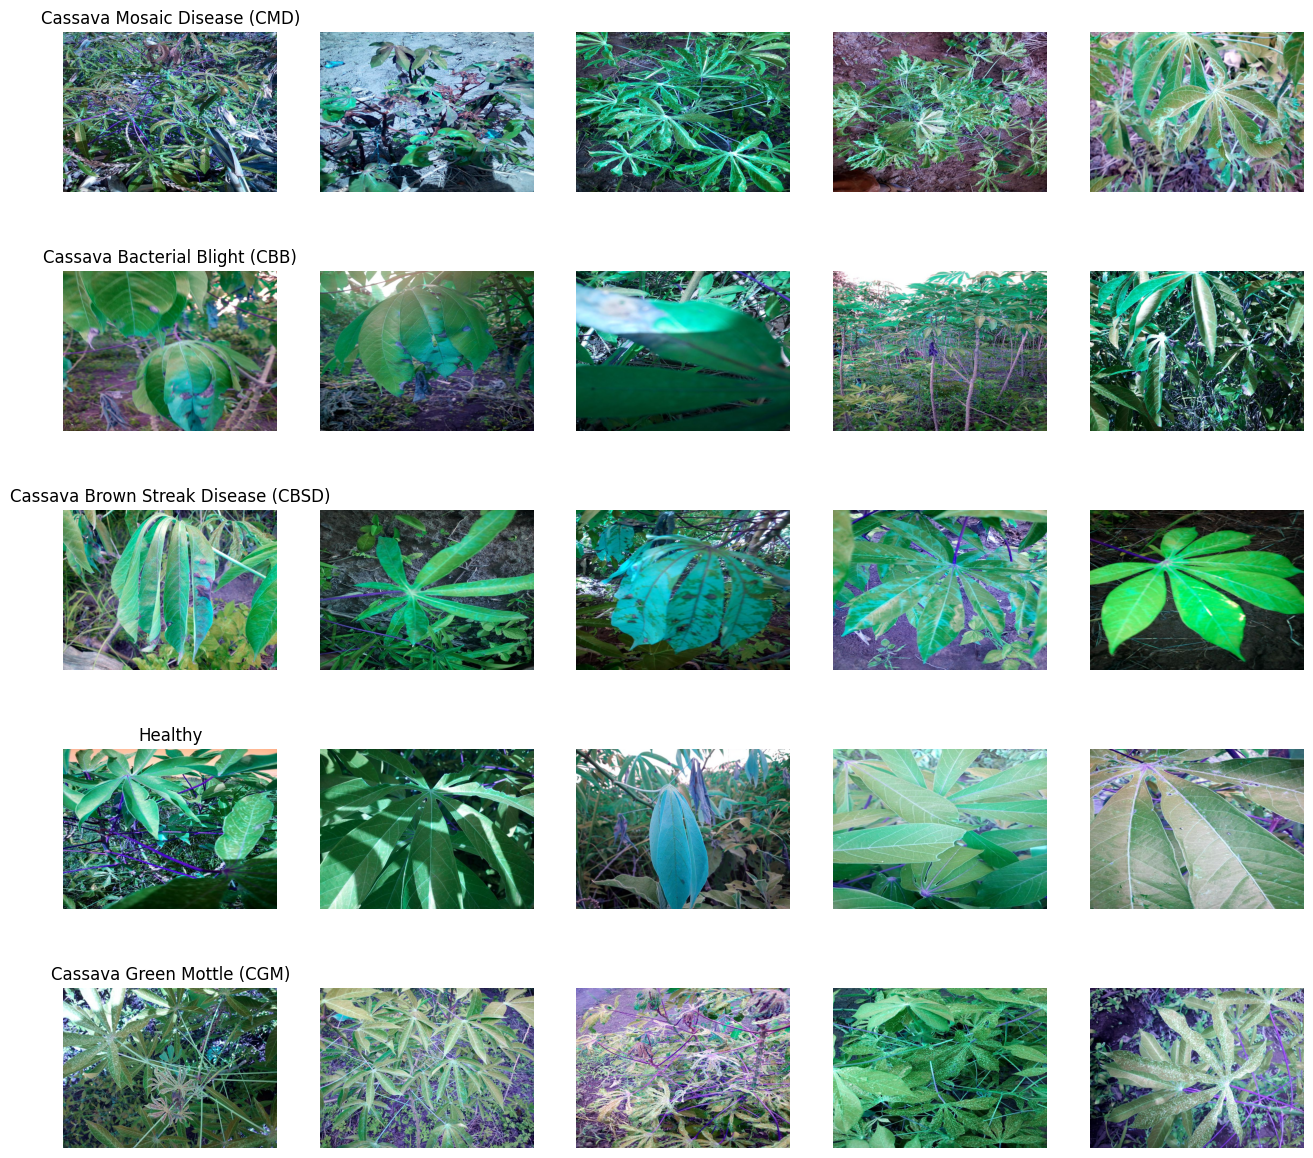

In [14]:
import cv2

_, ax = plt.subplots(5, 5, figsize=(16, 15))

for rownum, condition in enumerate(train.human_label.unique()):
    some_examples = train[train.human_label == condition].sample(5)
    for x in range(5):
        photo = some_examples.iloc[x]
        img = cv2.imread(photo.full_path)
        ax[rownum, x].imshow(img)
        if x==0:
            ax[rownum, x].set_title(photo.human_label)
        ax[rownum, x].axis('off')
plt.show()


It looks like the images are 800 by 600. I will shrink them down to 200 x 150 for starters.

In [15]:
for count, row in train_sample.iterrows():
    im = Image.open(row.full_path)
    print(im.size)

(800, 600)
(800, 600)
(800, 600)
(800, 600)
(800, 600)
(800, 600)
(800, 600)
(800, 600)
(800, 600)
(800, 600)


### Setting up the training/validation split

I am going to use ImageDataGenerator's built in train-test split here.


In [16]:
#https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = [200, 150]

idg = ImageDataGenerator(rescale=1./255,
    validation_split=0.2)

train_datagen = idg.flow_from_dataframe(
    train,
    horizontal_flip=True, 
    # I will experiment with more augmentation functions later on.
    x_col="full_path",
    y_col="human_label",
    target_size = IMAGE_SIZE,
    subset="training",

)

validation_datagen = idg.flow_from_dataframe(
    train,
    x_col="full_path",
    y_col="human_label",
    target_size = IMAGE_SIZE,
    subset="validation",
)


Found 14351 validated image filenames belonging to 5 classes.
Found 3587 validated image filenames belonging to 5 classes.


## First Model

For the first model, I am going to try something very very simple. just 3 convolutional layers. I used this basic design in a previous homework.

In [17]:
def getSimpleModel(input_shape=(*IMAGE_SIZE,3), num_classes=5):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    initializer = tf.random_normal_initializer(0., 0.02)
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.ZeroPadding2D(),

            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(num_classes, activation='softmax')
        ])
            

In [18]:
simple_model = getSimpleModel()

simple_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 202, 152, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 198, 148, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 196, 146, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 457856)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │     2,289,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,364,933 (9.02 MB)

 Trainable params: 2,364,933 (9.02 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
simple_model.compile(optimizer="adam", 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy()])

In [20]:

sm_hist = simple_model.fit(
    train_datagen,
    validation_data=validation_datagen,
    epochs=5
)
with open('sm_hist.json', 'w') as f:
    json.dump(sm_hist.history, f)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726505680.969663      64 service.cc:145] XLA service 0x797848005960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726505680.969737      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/449 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - categorical_accuracy: 0.1953 - loss: 3.3107   

I0000 00:00:1726505688.389654      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/449 ━━━━━━━━━━━━━━━━━━━━ 236s 499ms/step - categorical_accuracy: 0.5670 - loss: 1.6111 - val_categorical_accuracy: 0.6278 - val_loss: 1.0632
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 189ms/step - categorical_accuracy: 0.6822 - loss: 0.8625 - val_categorical_accuracy: 0.6415 - val_loss: 0.9976
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 187ms/step - categorical_accuracy: 0.9220 - loss: 0.2376 - val_categorical_accuracy: 0.5294 - val_loss: 1.4964
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 187ms/step - categorical_accuracy: 0.9854 - loss: 0.0513 - val_categorical_accuracy: 0.5408 - val_loss: 2.1627
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - categorical_accuracy: 0.9952 - loss: 0.0172 - val_categorical_accuracy: 0.6019 - val_loss: 2.6522


## Image Augmentation and Dropout

Yeah, so there's an obvious problem here, which is that validation loss keeps going up as training loss goes down. the model is overfitting almost right away which isn't surprising given the simplicity of the model. 

My first modification will be to do more image augmentation and add some dropout to the model.

In [21]:
train_datagen = idg.flow_from_dataframe(
    train,
    
    # image augmentation
    horizontal_flip=True, 
    rotation_range=90,
    zoom_range=[0.5,1.0],
    height_shift_range=0.25,
    width_shift_range=[-50,50],
    vertical_flip=True,
    
    x_col="full_path",
    y_col="human_label",
    target_size = IMAGE_SIZE,
    subset="training",

)

validation_datagen = idg.flow_from_dataframe(
    train,
    x_col="full_path",
    y_col="human_label",
    target_size = IMAGE_SIZE,
    subset="validation",
    shuffle=False
)


Found 14351 validated image filenames belonging to 5 classes.
Found 3587 validated image filenames belonging to 5 classes.


In [22]:
def getSimpleModel2(input_shape=(*IMAGE_SIZE,3), num_classes=5):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    initializer = tf.random_normal_initializer(0., 0.02)
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.ZeroPadding2D(),

            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5), # to reduce overfitting
            layers.Dense(num_classes, activation='softmax')
        ])

In [23]:
simple_model2 = getSimpleModel2()
simple_model2.compile(optimizer="adam", 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy()])

In [24]:
sm_hist_aug2 = simple_model2.fit(
    train_datagen,
    validation_data=validation_datagen,
    epochs=5
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 90s 192ms/step - categorical_accuracy: 0.5966 - loss: 1.4639 - val_categorical_accuracy: 0.6348 - val_loss: 1.0211
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - categorical_accuracy: 0.6745 - loss: 0.8614 - val_categorical_accuracy: 0.6270 - val_loss: 1.0071
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - categorical_accuracy: 0.8829 - loss: 0.3247 - val_categorical_accuracy: 0.5927 - val_loss: 1.3351
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 185ms/step - categorical_accuracy: 0.9631 - loss: 0.1189 - val_categorical_accuracy: 0.6083 - val_loss: 2.0213
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 187ms/step - categorical_accuracy: 0.9720 - loss: 0.0868 - val_categorical_accuracy: 0.6041 - val_loss: 2.2948


## Better, but not so great

It's not overfitting as fast, which is good. the max categorical accuracy is also a little better. But there's a problem. With 5 categories, an accuracy of .64 is certainly better than random chance. But we also have a major class imbalance. 61% of the images are of cassava mosaic disease:

In [25]:
train.human_label.value_counts() / len(train)

human_label
Cassava Mosaic Disease (CMD)           0.614729
Healthy                                0.120749
Cassava Green Mottle (CGM)             0.111105
Cassava Brown Streak Disease (CBSD)    0.102074
Cassava Bacterial Blight (CBB)         0.051344
Name: count, dtype: float64

That means we could achieve 61% accuracy by labeling everything mosaic disease. so this model really isn't doing much, if that's our baseline.

Let's look at the classification report:

In [26]:
## generating predictions
ground_truth = validation_datagen.classes
predictions = simple_model2.predict(validation_datagen)


## verifying how the 'val_categorical_accuracy' is calculated
truth_as_onehot = tf.keras.ops.one_hot(ground_truth, 5)

m = keras.metrics.CategoricalAccuracy()
m.update_state(truth_as_onehot, predictions)
m.result()


113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.60412604>

In [27]:

majority_prediction = predictions.argmax(axis=1)
print(classification_report(ground_truth, majority_prediction, target_names=labels.values()))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.31      0.12      0.17       162
Cassava Brown Streak Disease (CBSD)       0.26      0.13      0.18       349
         Cassava Green Mottle (CGM)       0.17      0.11      0.13       404
       Cassava Mosaic Disease (CMD)       0.72      0.88      0.79      2220
                            Healthy       0.28      0.24      0.26       452

                           accuracy                           0.60      3587
                          macro avg       0.35      0.30      0.31      3587
                       weighted avg       0.54      0.60      0.56      3587



and it wouldn't be a data science class without a confusion matrix, right?

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion = confusion_matrix(ground_truth, majority_prediction,normalize='true')

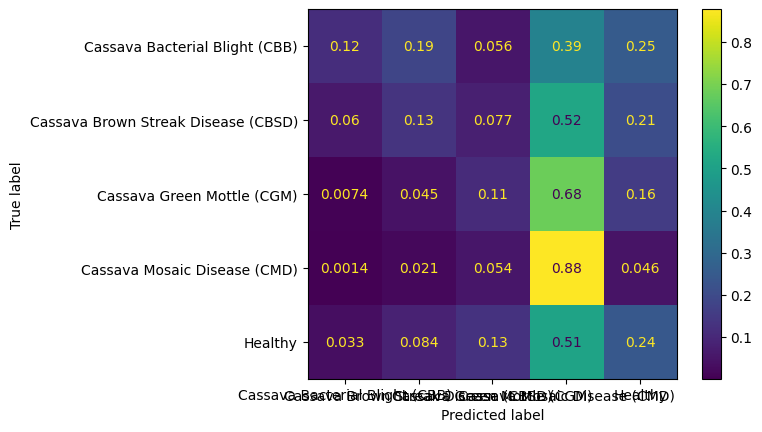

In [29]:
ConfusionMatrixDisplay(confusion, display_labels=labels.values()).plot()

It usually predicts Cassava Mosaic Disease for every class except for Cassava Bacterial Blight

Cassava Mosaic Disease is 61% of the training set but being predicted 75% of the time by this model.

In [30]:
pd.Series(majority_prediction).value_counts() / len(majority_prediction)

3    0.752161
4    0.108726
2    0.071926
1    0.050181
0    0.017006
Name: count, dtype: float64

what would the classification report look like if we just predicted Mosaic Disease every time?

In [31]:
all_mosaics = np.full(majority_prediction.shape, 3)
print(classification_report(ground_truth, all_mosaics, target_names=labels.values()))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00       162
Cassava Brown Streak Disease (CBSD)       0.00      0.00      0.00       349
         Cassava Green Mottle (CGM)       0.00      0.00      0.00       404
       Cassava Mosaic Disease (CMD)       0.62      1.00      0.76      2220
                            Healthy       0.00      0.00      0.00       452

                           accuracy                           0.62      3587
                          macro avg       0.12      0.20      0.15      3587
                       weighted avg       0.38      0.62      0.47      3587



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see the recall is 1 for mosaic because it predicted everything would be mosaic, and the precision is .62 because 62% of the sample is actually mosaic. 

Based of simple accuracy, this model is as good as our model. We're winning on the basis of _weighted average f1 score_, but try explaining that to someone at a party. Not impressive.

## Plan of Attack
I will try some more complex models.

I will correct for the class imbalance during the training procedure. We want the model to see roughly equal numbers of each class, even if the classes are imbalanced in real life. I will use the approach given in this StackOverflow answer: https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator

Transfer learning is using a pre trained general model, and then adapting it to a specific task. Since we don't have a lot of data, transfer learning should help.

I will experiment with a suite. The idea here is having a first model that predicts mosaic vs. non-mosaic (One Versus Many), then a second model that predicts the non-mosaic ones. 

## Fancier Model, Balanced Class Weights

The fancier model is one I developed for the cancer detection homework. It is based on the classic CNN architecture, and did quite well for that assignment. This is a much bigger model, so I will give it more epochs.

I am using balanced class weights for the training set but not the validation set. that means that what counts as a "good" score has changed. we should see lower accuracy scores for the training set (starting around 20% and then going up) than the validation set (hopefully over 60%).

In [32]:
## Step 1: A Faster Horse

def getFancyModel(input_shape=(*IMAGE_SIZE,3), num_classes=5):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    initializer = tf.random_normal_initializer(0., 0.02)
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),

            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),        

            layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),        

            layers.Conv2D(256, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(256, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)), 

            layers.Conv2D(512, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(512, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
        
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])
            

In [33]:
fancy_model = getFancyModel()
fancy_model.compile(optimizer="adam", 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy()])

In [34]:
## taken from https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator


class_weights = class_weight.compute_class_weight(
           'balanced',
            classes=np.unique(train_datagen.classes), 
            y=train_datagen.classes)

train_class_weights = dict(enumerate(class_weights))
#model.fit_generator(..., class_weight=train_class_weights)

In [35]:

checkpoint = ModelCheckpoint('best_fancy.keras', save_best_only=True, 
                             monitor='val_categorical_accuracy')

fancy_hist = fancy_model.fit(
    train_datagen,
    validation_data=validation_datagen,
    epochs=20,
    class_weight=train_class_weights,
    callbacks=[checkpoint]
)

Epoch 1/20
  2/449 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - categorical_accuracy: 0.3047 - loss: 1.9518   

I0000 00:00:1726506745.552937      66 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 4 bytes spill stores, 12 bytes spill loads



255/449 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - categorical_accuracy: 0.2004 - loss: 1.7321

I0000 00:00:1726506790.474195      66 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_15', 4 bytes spill stores, 12 bytes spill loads



449/449 ━━━━━━━━━━━━━━━━━━━━ 105s 207ms/step - categorical_accuracy: 0.2204 - loss: 12.3168 - val_categorical_accuracy: 0.4686 - val_loss: 1.4599
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - categorical_accuracy: 0.2231 - loss: 1.7896 - val_categorical_accuracy: 0.2975 - val_loss: 1.4584
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - categorical_accuracy: 0.2960 - loss: 1.5753 - val_categorical_accuracy: 0.4555 - val_loss: 1.3532
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 87s 191ms/step - categorical_accuracy: 0.3360 - loss: 1.5475 - val_categorical_accuracy: 0.6008 - val_loss: 1.2921
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 95s 209ms/step - categorical_accuracy: 0.3565 - loss: 1.5267 - val_categorical_accuracy: 0.4845 - val_loss: 1.2802
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - categorical_accuracy: 0.3899 - loss: 1.5059 - val_categorical_accuracy: 0.5166 - val_loss: 1.3533
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 88s 191ms/step - categorical_accuracy: 

The model went off a cliff in epoch 13 and never recovered. There is an element of luck to this stuff, as well as picking the right optimizer. But with a max accuracy of 60% (on the unbalanced validation set), it seems like this isn't really working. Maybe the results will tell us something. I used a callback to save the best one.

In [36]:
def model_report(file_name, datagen=validation_datagen):
    test_model = tf.keras.models.load_model(file_name)
    ground_truth = datagen.classes
    predictions = test_model.predict(datagen)
    majority_prediction = predictions.argmax(axis=1)
    _cr = classification_report(ground_truth, majority_prediction, 
                                target_names=labels.values())
    return _cr

In [37]:

    
print(model_report('best_fancy.keras'))

113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.21      0.48      0.29       162
Cassava Brown Streak Disease (CBSD)       0.26      0.07      0.11       349
         Cassava Green Mottle (CGM)       0.17      0.04      0.06       404
       Cassava Mosaic Disease (CMD)       0.69      0.90      0.78      2220
                            Healthy       0.25      0.08      0.12       452

                           accuracy                           0.60      3587
                          macro avg       0.32      0.31      0.27      3587
                       weighted avg       0.52      0.60      0.53      3587



because that was a weird run (register spill? that sounds bad), I'm trying again, with sgd instead of adam.

In [38]:
fancy_model = getFancyModel()
fancy_model.compile(optimizer="sgd", 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy()])

checkpoint = ModelCheckpoint('best_fancy2.keras', save_best_only=True, 
                             monitor='val_categorical_accuracy')

fancy_hist2 = fancy_model.fit(
    train_datagen,
    validation_data=validation_datagen,
    epochs=10,
    class_weight=train_class_weights,
    callbacks=[checkpoint]
)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 222ms/step - categorical_accuracy: 0.2196 - loss: 1.6091 - val_categorical_accuracy: 0.3106 - val_loss: 1.5976
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 97s 212ms/step - categorical_accuracy: 0.2374 - loss: 1.5954 - val_categorical_accuracy: 0.1985 - val_loss: 1.6992
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 96s 211ms/step - categorical_accuracy: 0.4208 - loss: 1.4940 - val_categorical_accuracy: 0.4672 - val_loss: 1.4789
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 246ms/step - categorical_accuracy: 0.4159 - loss: 1.4721 - val_categorical_accuracy: 0.5397 - val_loss: 1.2856
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 98s 215ms/step - categorical_accuracy: 0.4108 - loss: 1.4577 - val_categorical_accuracy: 0.5105 - val_loss: 1.3368
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - categorical_accuracy: 0.4286 - loss: 1.4009 - val_categorical_accuracy: 0.5394 - val_loss: 1.2316
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 96s 210ms/step - categorical

sigh. this doesn't seem to be going anywhere. on to the next thing.

## How suite it is (or isn't)

I wanted to try having two models, one that detects Cassava Mosaic Disease or not, and a second model that decides between the other 4 options if it's not Cassava Mosaic Disease.

That's only going to work well if we can distinguish mosaic vs. everybody with a high rate of accuracy but I figured it was worth a shot.

In [39]:
train['is_mosaic'] = (train.label==3).replace({True: 'True', False: 'False'})

these data generators are identical to before, except using is_mosaic for the y value.

In [40]:
mosaic_train_datagen = idg.flow_from_dataframe(
    train,
    
    # image augmentation
    horizontal_flip=True, 
    rotation_range=90,
    zoom_range=[0.5,1.0],
    height_shift_range=0.25,
    width_shift_range=[-50,50],
    vertical_flip=True,
    
    x_col="full_path",
    y_col="is_mosaic",
    target_size = IMAGE_SIZE,
    subset="training",
)

mosaic_validation_datagen = idg.flow_from_dataframe(
    train,
    x_col="full_path",
    y_col="is_mosaic",
    target_size = IMAGE_SIZE,
    subset="validation",
    shuffle=False,
)

Found 14351 validated image filenames belonging to 2 classes.
Found 3587 validated image filenames belonging to 2 classes.


I'm going to use the 2nd model (simple + dropout layer) rather than the fancy model that just crashed and burned. 

This is a binary classification problem, so the loss function and metrics are different.

I will balance the classes. So we're looking for an accuracy score higher than .5.

In [41]:
mosaic_model = getSimpleModel2(num_classes=2)

mosaic_model.compile(optimizer="adam", 
                     loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [42]:
checkpoint = ModelCheckpoint('best_mosaic.keras', save_best_only=True, 
                             monitor='val_accuracy')

mosaic_class_weights = class_weight.compute_class_weight(
           'balanced',
            classes=np.unique(mosaic_train_datagen.classes), 
            y=mosaic_train_datagen.classes)

mosaic_train_class_weights = dict(enumerate(mosaic_class_weights))

mosaic_hist = mosaic_model.fit(
    mosaic_train_datagen,
    validation_data=mosaic_validation_datagen,
    epochs=10,
    class_weight=mosaic_train_class_weights,
    callbacks=[checkpoint]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 93s 196ms/step - AUC: 0.6621 - accuracy: 0.6193 - loss: 0.7173 - val_AUC: 0.7780 - val_accuracy: 0.7103 - val_loss: 0.5823
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 187ms/step - AUC: 0.8533 - accuracy: 0.7667 - loss: 0.4751 - val_AUC: 0.7746 - val_accuracy: 0.7092 - val_loss: 0.6068
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 189ms/step - AUC: 0.9432 - accuracy: 0.8667 - loss: 0.3028 - val_AUC: 0.8144 - val_accuracy: 0.7466 - val_loss: 0.6036
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 188ms/step - AUC: 0.9802 - accuracy: 0.9370 - loss: 0.1701 - val_AUC: 0.7998 - val_accuracy: 0.7385 - val_loss: 0.7223
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 87s 191ms/step - AUC: 0.9891 - accuracy: 0.9574 - loss: 0.1134 - val_AUC: 0.7838 - val_accuracy: 0.7218 - val_loss: 0.8701
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 87s 192ms/step - AUC: 0.9899 - accuracy: 0.9638 - loss: 0.0966 - val_AUC: 0.7456 - val_accuracy: 0.6961 - val_loss: 1.2183
Epoch 7/10
449/449 ━━━━━━━━━━━━━━

I don't think 75% accuracy is good enough for the suite to be better than the *right* single model. So I will keep looking for that single model.

## Not Invented Here: Transfer Learning to the Rescue
Lots of people with way more money and training data than me have trained lots of models.The Cassava database is fairly small (18K), and we see much higher accuracy rates on the class with the most data (mosaic) versus the other classes, indicating a lack of data.

With transfer learning, we are able to benefit from previous research into the best models for image recognition, as well as the training done on that model.

I am going to start with the ResNet50 model. It has been trained on millions of photos from imagenet to classify images into one of 1000 classes. while none of those classes are Cassava disease related, by chopping off the last few layers of the imagenet model, we can retrain it to perform our desired task.

This was cribbed from: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33 However, I am using the default weights (imagenet) and the article is not.

When doing transfer learning, is customary to freeze the layers of the model that come from the pre trained model, so only the new layers at the end get modified. In this initial attempt, I did not do that, for both the sake of science and laziness. I'm only adding a single layer at the end, and none of the layers are frozen, so the learning will happen on top of the existing imagenet weights rather than in new layers.

In [43]:
from keras import applications


In [44]:

def get_res_net():
    base_model = applications.resnet50.ResNet50(input_shape=(224,224,3),
                                               include_top=False)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.7)(x)
    out_layer = layers.Dense(5, activation= 'softmax')(x)
    return keras.Model(inputs = base_model.input, outputs = out_layer)

transfer_model = get_res_net()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


the summary is a gigantic horror that I will not subject you to.

In [45]:
#transfer_model.summary()

We need new image data generators, because the shape of the images have changed. I have also eliminated the data augmentation, since we should be getting robustness from the pretrained ResNet model itself.

because we are using a pre trained network, best practice is to use the same preprocessing that was used to train the model.  

In [46]:
idg2 = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input,
    validation_split=0.2)

transfer_train_datagen = idg2.flow_from_dataframe(
    train,
    
    x_col="full_path",
    y_col="human_label",
    target_size = [224,224],
    subset="training",

)
transfer_validation_datagen = idg2.flow_from_dataframe(
    train,
    
    x_col="full_path",
    y_col="human_label",
    target_size = [224,224],
    subset="validation", 
    shuffle=False
)

Found 14351 validated image filenames belonging to 5 classes.
Found 3587 validated image filenames belonging to 5 classes.


In [47]:
transfer_class_weights = class_weight.compute_class_weight(
           'balanced',
            classes=np.unique(transfer_train_datagen.classes), 
            y=transfer_train_datagen.classes)

transfer_train_class_weights = dict(enumerate(transfer_class_weights))

I switched the optimizer from Adam to SGD becuase in my limited experience, it seems to work better on bigger models without having to tune the learning rate.



In [48]:
transfer_model.compile(optimizer="sgd", 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy()])

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_basic_transfer.keras', save_best_only=True, 
                             monitor='val_categorical_accuracy')

transfer_hist = transfer_model.fit(
    transfer_train_datagen,
    validation_data=transfer_validation_datagen,
    epochs=20,
    class_weight=transfer_train_class_weights,
    callbacks=[checkpoint]
)
with open('transfer_hist.json', 'w') as f:
    json.dump(transfer_hist.history, f)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 274ms/step - categorical_accuracy: 0.4683 - loss: 1.5581 - val_categorical_accuracy: 0.7126 - val_loss: 0.8066
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 226ms/step - categorical_accuracy: 0.7221 - loss: 0.8096 - val_categorical_accuracy: 0.7254 - val_loss: 0.7558
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 225ms/step - categorical_accuracy: 0.8176 - loss: 0.5466 - val_categorical_accuracy: 0.7209 - val_loss: 0.7747
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 104s 227ms/step - categorical_accuracy: 0.8760 - loss: 0.3334 - val_categorical_accuracy: 0.7103 - val_loss: 0.9643
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 104s 228ms/step - categorical_accuracy: 0.9109 - loss: 0.2322 - val_categorical_accuracy: 0.6769 - val_loss: 1.1564
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 102s 224ms/step - categorical_accuracy: 0.9288 - loss: 0.1875 - val_categorical_accuracy: 0.7435 - val_loss: 1.0058
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 226ms/step - categorical_accur

Nice, this looks much better than previous efforts. 

## Transfer Learning Results
These are the best results by far. It was still getting better at the end, so we could probably train it even further.

In [49]:
_mr = model_report('best_basic_transfer.keras', datagen=transfer_validation_datagen)
print(_mr)

113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 205ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.53      0.44      0.48       162
Cassava Brown Streak Disease (CBSD)       0.53      0.72      0.61       349
         Cassava Green Mottle (CGM)       0.83      0.48      0.61       404
       Cassava Mosaic Disease (CMD)       0.90      0.92      0.91      2220
                            Healthy       0.59      0.65      0.62       452

                           accuracy                           0.79      3587
                          macro avg       0.68      0.64      0.65      3587
                       weighted avg       0.80      0.79      0.79      3587



there appears to be a strong correlation between the precision and the support (number of data points). The more examples the model has seen, the better it is at recognizing that disease.

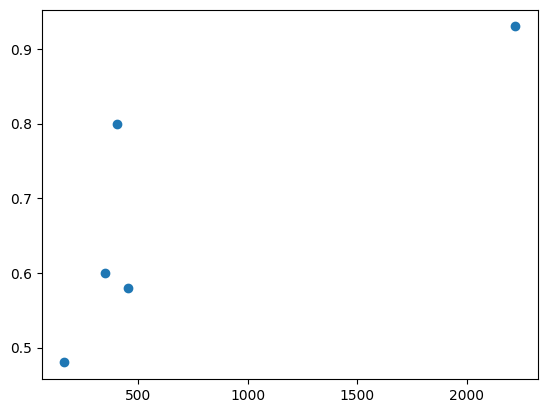

In [50]:
graph_x = [162,349,404,2220,452]
graph_y = [.48,.6,.8,.93,.58]

plt.scatter(graph_x, graph_y)

## Data Augmentation, again

I want to see if it was a mistake to take out the data augmentation. I'm on the verge of deciding we have a good model, but not enough data.

In [51]:
# add back in image augmentation. validation datagen doesn't need to change.
    
    
transfer_train_datagen = idg2.flow_from_dataframe(
    train,
    
    horizontal_flip=True, 
    rotation_range=90,
    zoom_range=[0.5,1.0],
    height_shift_range=0.25,
    width_shift_range=[-50,50],
    vertical_flip=True,
    
    x_col="full_path",
    y_col="human_label",
    target_size = [224,224],
    subset="training",

)

Found 14351 validated image filenames belonging to 5 classes.


In [52]:
transfer_model_aug = get_res_net()

In [53]:
transfer_model_aug.compile(optimizer="sgd", 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy()])

checkpoint = ModelCheckpoint('best_aug_transfer.keras', save_best_only=True, 
                             monitor='val_categorical_accuracy')

transfer_aug_hist = transfer_model_aug.fit(
    transfer_train_datagen,
    validation_data=transfer_validation_datagen,
    epochs=20,
    class_weight=transfer_train_class_weights,
    callbacks=[checkpoint]
)

with open('transfer_aug_hist.json', 'w') as f:
    json.dump(transfer_aug_hist.history, f)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 255ms/step - categorical_accuracy: 0.4445 - loss: 1.6913 - val_categorical_accuracy: 0.7457 - val_loss: 0.7099
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 101s 222ms/step - categorical_accuracy: 0.7253 - loss: 0.8275 - val_categorical_accuracy: 0.6326 - val_loss: 0.9599
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 102s 224ms/step - categorical_accuracy: 0.7994 - loss: 0.5741 - val_categorical_accuracy: 0.7664 - val_loss: 0.6941
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 144s 228ms/step - categorical_accuracy: 0.8722 - loss: 0.3557 - val_categorical_accuracy: 0.5718 - val_loss: 1.4267
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 227ms/step - categorical_accuracy: 0.9145 - loss: 0.2091 - val_categorical_accuracy: 0.7898 - val_loss: 0.8110
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 226ms/step - categorical_accuracy: 0.9455 - loss: 0.1424 - val_categorical_accuracy: 0.7204 - val_loss: 0.9901
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 101s 222ms/step - categorical_accur

In [54]:
_mr2 = model_report('best_aug_transfer.keras', datagen=transfer_validation_datagen)
print(_mr2)

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.55      0.55      0.55       162
Cassava Brown Streak Disease (CBSD)       0.74      0.64      0.68       349
         Cassava Green Mottle (CGM)       0.73      0.63      0.68       404
       Cassava Mosaic Disease (CMD)       0.90      0.94      0.92      2220
                            Healthy       0.63      0.63      0.63       452

                           accuracy                           0.82      3587
                          macro avg       0.71      0.68      0.69      3587
                       weighted avg       0.82      0.82      0.82      3587



This model is even better than the previous one, and this is the first model with precision > .5 for all five of the categories.

## The Frozen Model: An Ice Solution?
Let's try the traditional transfer learning approach of freezing the ResNet layers and adding some layers at the end. I couldn't find clear direction on how many layers, or what structure, so I just cribbed off this article  https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b 

In [55]:
# we are using the default (trained) weights
base_model = applications.resnet50.ResNet50(input_shape=(224,224,3),
                                           include_top=False)
## this is where the resnet layers get frozen.
base_model.trainable=False

## you can't put the resnet model in a keras.Sequential([]), for reasons
## that I don't understand. so I have to use the more awkward syntax here.

x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='leaky_relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(5, activation= 'softmax')(x)
transfer_freeze_model = keras.Model(inputs = base_model.input, outputs = predictions)

In [56]:
transfer_freeze_model.compile(optimizer="sgd", 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy()])

checkpoint = ModelCheckpoint('best_freeze_transfer.keras', save_best_only=True, 
                             monitor='val_categorical_accuracy')

transfer_freeze_hist = transfer_freeze_model.fit(
    transfer_train_datagen,
    validation_data=transfer_validation_datagen,
    epochs=20,
    class_weight=transfer_train_class_weights,
    callbacks=[checkpoint]
)
with open('transfer_freeze_hist.json', 'w') as f:
    json.dump(transfer_freeze_hist.history, f)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 122s 251ms/step - categorical_accuracy: 0.4633 - loss: 2.7620 - val_categorical_accuracy: 0.5933 - val_loss: 1.0323
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 226ms/step - categorical_accuracy: 0.6713 - loss: 0.8978 - val_categorical_accuracy: 0.5941 - val_loss: 1.0806
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 107s 234ms/step - categorical_accuracy: 0.7547 - loss: 0.5869 - val_categorical_accuracy: 0.6680 - val_loss: 0.9763
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 238ms/step - categorical_accuracy: 0.8170 - loss: 0.3891 - val_categorical_accuracy: 0.6671 - val_loss: 1.1098
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 247ms/step - categorical_accuracy: 0.8676 - loss: 0.2929 - val_categorical_accuracy: 0.6936 - val_loss: 1.1497
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 106s 233ms/step - categorical_accuracy: 0.8981 - loss: 0.2047 - val_categorical_accuracy: 0.7017 - val_loss: 1.2191
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 110s 242ms/step - catego

this model does fine but it doesn't seem able to break the 80% accuracy the previous model got. Maybe it's not sophisticated enough? I only added a single layer to the end.

In [57]:
base_model = applications.resnet50.ResNet50(input_shape=(224,224,3),
                                           include_top=False)
## this is where the resnet layers get frozen.
base_model.trainable=False

## you can't put the resnet model in a keras.Sequential([]), for reasons
## that I don't understand. so I have to use the more awkward syntax here.

# architecture based on https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b 
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
predictions = layers.Dense(5, activation= 'softmax')(x)
transfer_freeze_model2 = keras.Model(inputs = base_model.input, outputs = predictions)

In [58]:
#transfer_freeze_model2.summary()

In [59]:
transfer_freeze_model2.compile(optimizer="sgd", 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy()])

checkpoint = ModelCheckpoint('best_freeze_transfer2.keras', save_best_only=True, 
                             monitor='val_categorical_accuracy')

transfer_freeze2_hist = transfer_freeze_model2.fit(
    transfer_train_datagen,
    validation_data=transfer_validation_datagen,
    epochs=20,
    class_weight=transfer_train_class_weights,
    callbacks=[checkpoint]
)
with open('transfer_freeze2_hist.json', 'w') as f:
    json.dump(transfer_freeze2_hist.history, f)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 254ms/step - categorical_accuracy: 0.2639 - loss: 1.9100 - val_categorical_accuracy: 0.3922 - val_loss: 1.4606
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 105s 232ms/step - categorical_accuracy: 0.3692 - loss: 1.5021 - val_categorical_accuracy: 0.4734 - val_loss: 1.3303
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 293ms/step - categorical_accuracy: 0.4376 - loss: 1.3755 - val_categorical_accuracy: 0.5149 - val_loss: 1.2883
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 297ms/step - categorical_accuracy: 0.4897 - loss: 1.3248 - val_categorical_accuracy: 0.5461 - val_loss: 1.2032
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 107s 236ms/step - categorical_accuracy: 0.4967 - loss: 1.3015 - val_categorical_accuracy: 0.5578 - val_loss: 1.1597
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 110s 242ms/step - categorical_accuracy: 0.5374 - loss: 1.2426 - val_categorical_accuracy: 0.6027 - val_loss: 1.1220
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 238ms/step - catego

In [60]:
# transfer_freeze2_hist2 = transfer_freeze_model2.fit(
#     transfer_train_datagen,
#     validation_data=transfer_validation_datagen,
#     epochs=5,
#     class_weight=transfer_train_class_weights,
#     callbacks=[checkpoint]
# )

halted because I'm almost out of run time, and it's not going anywhere. It's weird that categorical accuracy never seems to get above 60ish percent.

In [61]:
_mr3 = model_report('best_freeze_transfer.keras', datagen=transfer_validation_datagen)
print(_mr3)

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.43      0.39      0.41       162
Cassava Brown Streak Disease (CBSD)       0.53      0.48      0.50       349
         Cassava Green Mottle (CGM)       0.46      0.42      0.44       404
       Cassava Mosaic Disease (CMD)       0.86      0.87      0.86      2220
                            Healthy       0.50      0.56      0.53       452

                           accuracy                           0.72      3587
                          macro avg       0.55      0.54      0.55      3587
                       weighted avg       0.72      0.72      0.72      3587



## Model Comparison
Are these models making the same mistakes, or different ones?

In [62]:
freeze = tf.keras.models.load_model('best_freeze_transfer.keras')
aug = tf.keras.models.load_model('best_aug_transfer.keras')
basic = tf.keras.models.load_model('best_basic_transfer.keras')

freeze_preds = freeze.predict(transfer_validation_datagen)
aug_preds = aug.predict(transfer_validation_datagen)
basic_preds = basic.predict(transfer_validation_datagen)

predictions_df = pd.DataFrame({"freeze": freeze_preds.argmax(axis=1), 
                               "aug": aug_preds.argmax(axis=1), 
                               "basic": basic_preds.argmax(axis=1), 
                               "truth": validation_datagen.classes})

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step


In [63]:
predictions_df.sample(10)

,freeze,aug,basic,truth
2568,3,3,3,3
2698,3,3,3,3
2808,3,3,3,3
589,3,3,3,3
1833,3,2,3,3
1247,3,2,3,3
3190,3,3,3,3
1111,3,3,3,3
2186,3,3,3,3
295,3,3,3,3


How often do they all agree with each other?

(edit: not sure why the only class is '3' in the above results, since I took a random sample)

In [64]:
total_preds = len(predictions_df)

consensus = predictions_df[(predictions_df.basic == predictions_df.aug) & 
               (predictions_df.aug == predictions_df.freeze)]
print(len(consensus)/ total_preds)


0.667131307499303


so 67% of the time, they all give the same answer. that's less agreement than I was expecting. It makes me think a suite using all 3 models could work. It's easy to test.

## Suite Revenge!

What if we just average together the 3 best models?

In [65]:
combo = freeze_preds + aug_preds + basic_preds

predictions_df['combo'] = combo.argmax(axis=1)

print(classification_report(predictions_df.truth, predictions_df.combo, target_names=labels.values()))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.60      0.53      0.56       162
Cassava Brown Streak Disease (CBSD)       0.67      0.68      0.67       349
         Cassava Green Mottle (CGM)       0.83      0.56      0.67       404
       Cassava Mosaic Disease (CMD)       0.90      0.95      0.93      2220
                            Healthy       0.64      0.68      0.66       452

                           accuracy                           0.83      3587
                          macro avg       0.73      0.68      0.70      3587
                       weighted avg       0.83      0.83      0.82      3587



that's our best score so far. it's a little surprising that averaging the models together worked, considering the 3 we used were all transfer models with the same inital weights. so their results should be very similar. So why it worked is an open question. But it did!

## Conclusions

I investigated several models for classifying diseases of the Cassava plant. 

* After many failed attempts, I finally constructed a model that does better than chance by using transfer learning and balancing the classes in the training data.
* Doing transfer learning the "right" way yielded worse results than training over the existing imagenet weights.
* Averaging the best 3 models together yielded better results than any individual model
* Data augmentation was beneficial, even with transfer learning

Here's a summary of the results of our models. I am showing the worst performing precision for the 5 categories.

|Model Name|Accuracy|Weighted Avg F1|Worst Precision
|----------|--------|---------------|---------------|
|Trivial | .62|.47|0.0
|Simple + Dropout | .60 | .56 | .17
| Fancy | .60 | .53 | .17
|Transfer |.79|.79|.53
|Transfer + Aug|.82|.82|.55
|Frozen|.72|.72|.43
|Suite|.83|.82|.60

### Discussion and next steps

I wish I had known that transfer learning was the right way, because I could have tested more pretrained models (such as rexnet, which is an improvement on resnet). And I suspect that a suite of models with different structures might do even better. I would want to try to combine the models in a more sophisticated way, within a larger keras model. That model would combine the raw results with additional layers that would be trained after freezing the individual models.

However, with every model I created, the classes with fewer photos had lower accuracy. So more real world data would undoubtedly produce better results regardless of model used.